# Imports

In [1]:
# import packaed for reading in data
from pyspark.sql import SparkSession
from pyspark.context import SparkContext

# import packages for types
from pyspark.sql.types import IntegerType, DoubleType

# import functions for getting substring
from pyspark.sql.functions import substring

# import functions for model
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# import packages for turning the recommendations into seperate columns
from pyspark.sql.functions import col, explode

# import packages for interactively selecting user
from ipywidgets import widgets, interact

# Read in the data

We will be using the movielens dataset for this recommender system.
The data on the movies and their ratings was uploaded to the HDFS and then cleaned in PIG to fix the columns. All of the movie and rating data was then joined into one table. This cleaned table was stored on the HDFS which is where we read this file in from.

In [3]:
#sc = SparkContext('local')
#spark = SparkSession(sc)
read_df = spark.read.csv("hdfs://cluster-1-m/user/Owner/output/cleaned_movies_nd_ratings", sep="|")

In [4]:
read_df.count()

100836

#### Rename the columns

In [5]:
renamed_cols_df = read_df.withColumnRenamed("_c0", "movie_id")\
                         .withColumnRenamed("_c1", "title")\
                         .withColumnRenamed("_c2", "year")\
                         .withColumnRenamed("_c3", "genres")\
                         .withColumnRenamed("_c4", "user_id")\
                         .withColumnRenamed("_c5", "rating")\
                         .withColumnRenamed("_c6", "timestamp")

#### Sort the datatypes

In [6]:
# Quick look at the schema features and data types
renamed_cols_df.printSchema()

root
 |-- movie_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- year: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [7]:
fixed_types_df = renamed_cols_df.withColumn("movie_id", renamed_cols_df["movie_id"].cast(IntegerType()))\
                                .withColumn("year", renamed_cols_df["year"].cast(IntegerType()))\
                                .withColumn("user_id", renamed_cols_df["user_id"].cast(IntegerType()))\
                                .withColumn("rating", renamed_cols_df["rating"].cast(DoubleType()))\
                                .withColumn("timestamp", renamed_cols_df["timestamp"].cast(IntegerType()))

In [8]:
fixed_types_df.printSchema()

root
 |-- movie_id: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- year: integer (nullable = true)
 |-- genres: string (nullable = true)
 |-- user_id: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



#### Drop not needed columns

In [9]:
df = fixed_types_df.drop("timestamp")

#### Manually check this dataframe

We will do some brief analysis of the dataset here to get a feel for its contents. This analysis will hope to inform us when it comes to designing the recommender system.

In [10]:
df.show(10)

+--------+---------+----+--------------------+-------+------+
|movie_id|    title|year|              genres|user_id|rating|
+--------+---------+----+--------------------+-------+------+
|       1|Toy Story|1995|(Adventure,Animat...|    314|   3.0|
|       1|Toy Story|1995|(Adventure,Animat...|    240|   5.0|
|       1|Toy Story|1995|(Adventure,Animat...|    500|   4.0|
|       1|Toy Story|1995|(Adventure,Animat...|     90|   3.0|
|       1|Toy Story|1995|(Adventure,Animat...|     89|   3.0|
|       1|Toy Story|1995|(Adventure,Animat...|    504|   4.0|
|       1|Toy Story|1995|(Adventure,Animat...|     91|   4.0|
|       1|Toy Story|1995|(Adventure,Animat...|     86|   4.0|
|       1|Toy Story|1995|(Adventure,Animat...|    509|   4.0|
|       1|Toy Story|1995|(Adventure,Animat...|    492|   4.0|
+--------+---------+----+--------------------+-------+------+
only showing top 10 rows



#### See how many users and movies there are

In [11]:
print "There are", df.select("user_id").dropDuplicates().count(), "users in this dataset."

There are 610 users in this dataset.


In [12]:
print "There are", df.select("movie_id").dropDuplicates().count(), "movies in this dataset."

There are 9724 movies in this dataset.


#### See what their max and min values are

In [13]:
print "Min user_id =", df.agg({"user_id": "min"}).collect()[0]
print "Max user_id =", df.agg({"user_id": "max"}).collect()[0]

Min user_id = Row(min(user_id)=1)
Max user_id = Row(max(user_id)=610)


In [14]:
print "Min movie_id =", df.agg({"movie_id": "min"}).collect()[0]
print "Max movie_id =", df.agg({"movie_id": "max"}).collect()[0]

Min movie_id = Row(min(movie_id)=1)
Max movie_id = Row(max(movie_id)=193609)


In [15]:
df.select(["movie_id", "title"]).drop_duplicates().show(10)

+--------+--------------------+
|movie_id|               title|
+--------+--------------------+
|      29|City of Lost Chil...|
|     775| Spirits of the Dead|
|     848| Spitfire Grill, The|
|     946|  To Be or Not to Be|
|    1120|People vs. Larry ...|
|    1136|Monty Python and ...|
|    1799|       Suicide Kings|
|    1882|            Godzilla|
|    1928|            Cimarron|
|    2344|       Runaway Train|
+--------+--------------------+
only showing top 10 rows



#### Check if there are users with multiple ratings on a particular movie

In [16]:
if df["movie_id", "user_id"].count() > df.dropDuplicates(["movie_id", "user_id"]).count():
    raise ValueError('Data has duplicates')

# Calculate the sparcity of a users vs movies matrix

A utility matrix is a matric where all of the movies are listed as the columns and all of the users are listed as the rows. Then the intersection values between the movies and a users are filled in as the ratings that the particular user gave to that movie.
An example of this is as follows:
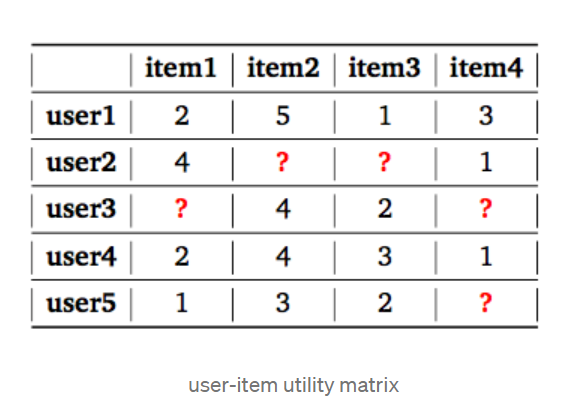

As most users will not have rated many of the thousands of movies in the dataset, this matrix will contain mostly null values. The % sparcity of this matrix can be calculated as follows:

In [22]:
# Count the total number of ratings in the dataset
num_ratings = df.select("rating").count()

# Count the number of distinct userIds and distinct movieIds
num_users = df.select("user_id").distinct().count()
num_movies = df.select("movie_id").distinct().count()

In [23]:
# Caluclate the sparsity
sparsity = (1.0 - ((num_ratings * 1.0) / (num_users * num_movies))) * 100

print "The ratings dataframe is %.2f" % sparsity + "% empty."

The ratings dataframe is 98.30% empty.


# Build recommender model

Here we will build our recommender system using this utility matrix. This process involves a few steps:
    1. Splitting the data into a train and test set
    2. Creating the model
    3. Fitting he model to the data
    4. Evaluating the model
    5. Making the recommendation
    
As there are a lot of inbuilt functions, a lot of these steps are reasonably straight forward to do.

There are two main approaches to recommendation, these are **content based filtering** recommendation and a **collaborative filtering** recommendation.

A recommendation using content based filtering is one where the recommendation is based on the content, which in our case is the movie. Using this method, a movie would be run through the recommender system and the system would spit back other movies based on this movie.

A recommendation using collaborative filtering is one where the recommendation is based on similarity between collaborators in the data, which in our case are the users. Using this method, we run a user through the recommender system and the system returns recommended movies to watch based on movie ratings that similar users to that user did.

This is nicely visualised in the following diagram which was sourced from https://towardsdatascience.com/build-recommendation-system-with-pyspark-using-alternating-least-squares-als-matrix-factorisation-ebe1ad2e7679
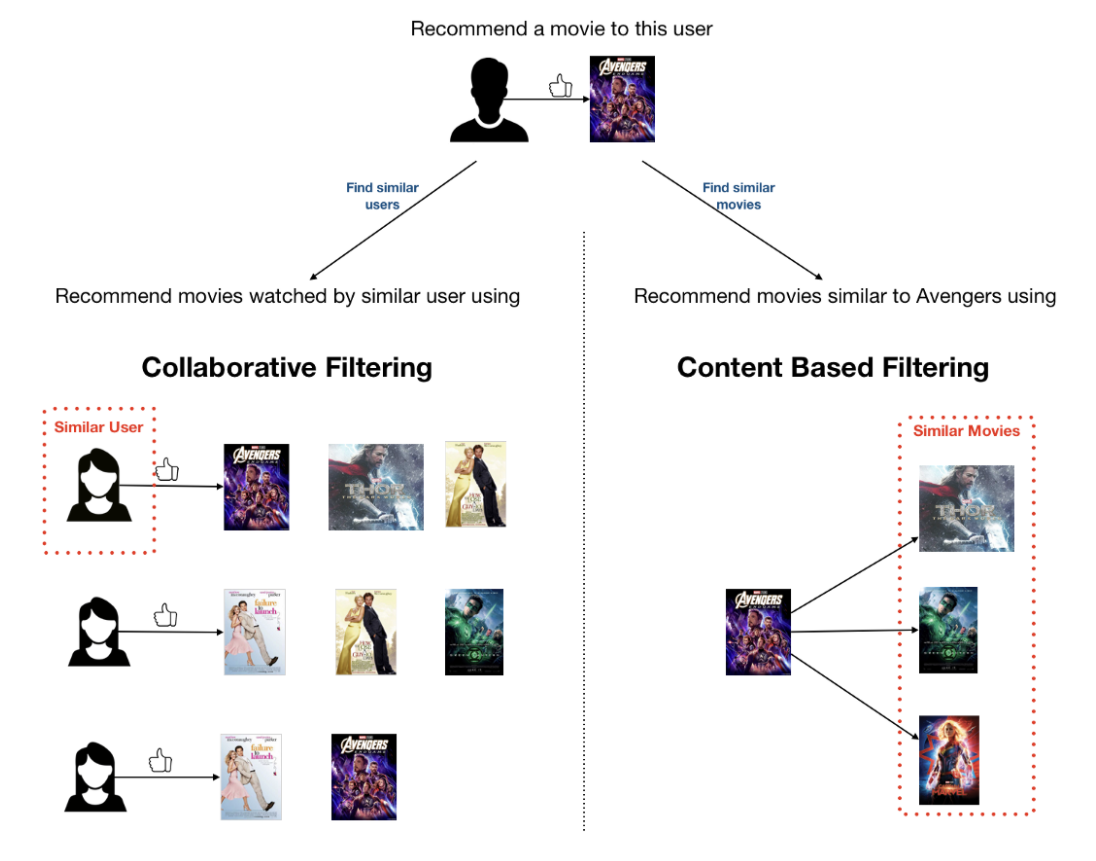

In our case, we will use Collaborative filtering.

#### Split the data into a train & test split

I decided that a train-test split of 80-20 was sufficient for this use case. 80-20 is a fairly standard split ratio. The random seed of 42 was chosen as it is also a very common random seed.

In [17]:
# Split the data to create a test and train set
train, test = df.randomSplit([0.8, 0.2], seed = 42)

#### Create model

The particular technique we will use to factorise the utility matrix is Alternating Least Squares (ALS). This collaborative filtering technique is implemented in Apache Spark ML and runs in a parallel manor. It is good at dealing with large sparse matricies similar to the one we have with our users and movies.

This approach lends itself easily to item-based collaborative filtering and user-based collaborative filtering which gives us more options when it comes to our recommendations.

In [18]:
# Create ALS model
als = ALS(userCol="user_id", itemCol="movie_id", ratingCol="rating", nonnegative=True, implicitPrefs=False, coldStartStrategy="drop")

#### Fit the model to the trainind data

In [19]:
# train out model by fitting it to the training data
model = als.fit(train)

#### Evaluate the model

The test set comes in to evaluate the model that was trained on the training set. We first run this test set through the model to get a prediction and we then use an evaluation metric to measure the models accuracy.

The evaluation metric we will use is Root Mean Squared Error (RMSE), this metric measures the difference between the predicted value and the actual value and aggregates the error across all of the different ratings into one single metric.
This error metric is always a positive value as no data can have a negative error, but can only have no error. The closer the metric is to 0, the better the predictive power of our model is.

In [20]:
# run the test set through the model to get a prediction
predictions = model.transform(test)

In [21]:
# Compare the user rating to the predicted rating
predictions.show(10)

+--------+--------------------+----+--------------------+-------+------+----------+
|movie_id|               title|year|              genres|user_id|rating|prediction|
+--------+--------------------+----+--------------------+-------+------+----------+
|     471|Hudsucker Proxy, The|1994|            (Comedy)|    500|   1.0| 3.6545558|
|     471|Hudsucker Proxy, The|1994|            (Comedy)|     57|   3.0| 3.2691827|
|     471|Hudsucker Proxy, The|1994|            (Comedy)|    462|   2.0|   2.83155|
|     471|Hudsucker Proxy, The|1994|            (Comedy)|    610|   4.0| 3.4102268|
|     471|Hudsucker Proxy, The|1994|            (Comedy)|    520|   5.0| 3.3425498|
|     471|Hudsucker Proxy, The|1994|            (Comedy)|    171|   3.0| 4.1188407|
|     471|Hudsucker Proxy, The|1994|            (Comedy)|    426|   5.0|  2.498088|
|     471|Hudsucker Proxy, The|1994|            (Comedy)|    357|   3.0| 3.5415242|
|    1088|       Dirty Dancing|1987|(Drama,Musical,Ro...|    554|   5.0| 4.1

First visualising a side by side comparison of these rating and predicted ratings, we can see that the predicted ratings aren't too bad. While a few of them are off, others are quite close to eachother.

We will now attempt to get an official metric on the accuracy of these predictions.

In [22]:
# Define an evaluator using RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

In [23]:
# evaluate model performance
rmse = evaluator.evaluate(predictions)

print("Root-mean-square error = " + str(rmse))

Root-mean-square error = 0.924886877152


We can see that our RMSE is 0.925 which is reasonable. This means that each predicted rating is on average off by 0.925 stars. As our ratings go from 0 to 5, this works out to be about an 81% accuracy, which is quite decent and gives hope that we can get some good recommendations with our algorithms.

# Recommend movies

At this stage all the preperation is done and we can move onto making the recommendations.

This will be broke down into 3 different types of recommendation:
    1. Generating a recommendation of 'n' movies for each user in the dataset
    2. Making 'n' movie recommendations for a specific user from the dataset (can also be changed to 'k' users)
    3. Picking 'm' movies and then selecting 'u' users to recommend this movie to
    
The generalisability of the model lends itself well to these recommendation types. 

### 1. Generate recommendation for all users

The first recommendation we will do is a recommendation for all users.
Here we select the number of movies we want to recommend to each user and then run the 'recommendForAllUsers' function on the model. This function compares each user to the other users and based on similar users that like the same type of movies, it will recommend 'n' movies for that user to watch.

This is a user-based collaborative filtering approach and could be used in the likes of Netflix recommendations where we recommend movies to each user with an account.

In [24]:
num_movies_to_recommend = 5

In [25]:
# Generate n Recommendations for all users
recommendations_for_users = model.recommendForAllUsers(num_movies_to_recommend)

We can see the recommendations given to each user in a table.

In [26]:
recommendations_for_users.limit(10).show(truncate=False)

+-------+--------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                   |
+-------+--------------------------------------------------------------------------------------------------+
|471    |[[171495, 4.449134], [3677, 4.4246325], [3266, 4.4195385], [7121, 4.381981], [33649, 4.336961]]   |
|463    |[[7121, 4.628688], [26171, 4.5963597], [2295, 4.5551105], [6201, 4.5551105], [4495, 4.5551105]]   |
|496    |[[51931, 4.8322306], [932, 4.6632023], [3819, 4.60512], [3266, 4.5654616], [306, 4.5265884]]      |
|148    |[[6380, 4.7784023], [6732, 4.7309885], [5034, 4.6771827], [33649, 4.6433926], [1046, 4.6124983]]  |
|540    |[[7842, 5.293226], [171495, 5.235217], [141718, 5.177737], [33649, 5.1200557], [7071, 5.092456]]  |
|392    |[[27611, 5.1704335], [2730, 5.07279], [171495, 5.0011835], [232, 4.993888], [3677, 4.95216]]      |
|243    |[[6433, 6.

We can turn this recommendations column into two columns for easier visualisation of the recommended movies. This gves the following:

In [27]:
user_rec_nd_pred_rating = recommendations_for_users.withColumn("exploded_rec", explode("recommendations"))\
                                                   .select('user_id', col("exploded_rec.movie_id"), col("exploded_rec.rating"))

user_rec_nd_pred_rating.limit(10).show()

+-------+--------+---------+
|user_id|movie_id|   rating|
+-------+--------+---------+
|    471|  171495| 4.449134|
|    471|    3677|4.4246325|
|    471|    3266|4.4195385|
|    471|    7121| 4.381981|
|    471|   33649| 4.336961|
|    463|    7121| 4.628688|
|    463|   26171|4.5963597|
|    463|    2295|4.5551105|
|    463|    6201|4.5551105|
|    463|    4495|4.5551105|
+-------+--------+---------+



Each user now has 5 recommended movies assigned to them by the recommender system. These movies are based of a predicted rating of what each user would rate each movie and the top 'n' predicted rated movies for each user are chosen.

We can further dive into a specific user and see **how the recommendations compare to the users actual highly rated movies**.

The example below follows the user with user_id of 12.

* Recommended movies

In [28]:
user_rec_nd_pred_rating.join(df.drop('user_id', 'rating').dropDuplicates(), ['movie_id'], how='left') \
                       .select(col('user_id'), col('movie_id'), col('title'), col('year'), col('genres'), col('rating')) \
                       .filter('user_id = 12') \
                       .sort('rating', ascending=False).limit(10).show(truncate=False)

+-------+--------+-------------+----+----------------------+---------+
|user_id|movie_id|title        |year|genres                |rating   |
+-------+--------+-------------+----+----------------------+---------+
|12     |3567    |Bossa Nova   |2000|(Comedy,Drama,Romance)|6.612814 |
|12     |112804  |I Origins    |2014|(Drama,Sci-Fi)        |6.419753 |
|12     |51931   |Reign Over Me|2007|(Drama)               |6.4145527|
|12     |33649   |Saving Face  |2004|(Comedy,Drama,Romance)|6.202682 |
|12     |47423   |Half Nelson  |2006|(Drama)               |6.150974 |
+-------+--------+-------------+----+----------------------+---------+



* Users top rated movies

In [29]:
df.select(df.user_id, df.movie_id, df.title, df.year, df.genres, df.rating) \
  .filter('user_id = 12') \
  .sort('rating', ascending=False).limit(10).show(truncate=False)

+-------+--------+--------------------------+----+-----------------------+------+
|user_id|movie_id|title                     |year|genres                 |rating|
+-------+--------+--------------------------+----+-----------------------+------+
|12     |1721    |Titanic                   |1997|(Drama,Romance)        |5.0   |
|12     |2717    |Ghostbusters II           |1989|(Comedy,Fantasy,Sci-Fi)|5.0   |
|12     |2072    |'burbs, The               |1989|(Comedy)               |5.0   |
|12     |222     |Circle of Friends         |1995|(Drama,Romance)        |5.0   |
|12     |2485    |She's All That            |1999|(Comedy,Romance)       |5.0   |
|12     |838     |Emma                      |1996|(Comedy,Drama,Romance) |5.0   |
|12     |2572    |10 Things I Hate About You|1999|(Comedy,Romance)       |5.0   |
|12     |1357    |Shine                     |1996|(Drama,Romance)        |5.0   |
|12     |2581    |Never Been Kissed         |1999|(Comedy,Romance)       |5.0   |
|12     |256    

Here we have shown the users top 10 rated movies and then the 5 movies that the system recommends for this given user. As you can see from the users highly rated movies, the genres of these movies are most commonly Drama, Romance and Comody. It can also be seen that our recommendation system has taken this on board and has recommended movies with the genres Comody, Drama and Romance.

This shows the effectiveness of the recommender system's recommendations.

### 2. Recommend for specific user

The next recommendation type we will look at taking a specific users and then making a recommendation of 'n' movies for this user. This is similar to the above recommendation for all users except here we only recommend for one user.

I have set this up so that the user can be interactively chosen from all of the users in the dataset. From above we saw there was 610 users with user_id's ranging from 1 to 610 in increments of 1. I used this to create a slider where you can interactively select which user_id to make the recommendations for.

In [44]:
slider_variable = widgets.Text()

def set_slider_val(x):
    slider_variable.value = str(x)
    
_ = interact(set_slider_val, x=widgets.IntSlider(min=1, max=610, step=1, value=304))

interactive(children=(IntSlider(value=304, description=u'x', max=610, min=1), Output()), _dom_classes=('widget-interact',))

The value returned by this slider must then be turned to an interger so that it can be used to make the recommendations

In [45]:
specific_user_id = int(slider_variable.value)
specific_user_id

304

In [46]:
specific_user = df.select(als.getUserCol()).distinct().filter((df.user_id == specific_user_id))
specific_user.show()

+-------+
|user_id|
+-------+
|    304|
+-------+



In [47]:
# get top 'n' movie recommendations for the above selected user
num_movie_recommendations = 10
specifc_user_recommendation = model.recommendForUserSubset(specific_user, num_movie_recommendations)

In [48]:
# turn the recommendation column into multiple columns for easy visualisation
exploded_specific_rec = specifc_user_recommendation.withColumn("exploded_rec", explode("recommendations"))\
                                                   .select('user_id', col("exploded_rec.movie_id"), col("exploded_rec.rating"))

Again after generating the recommendations, we can compare this users recommendation with their actual top rated movies.

* Recommended movies

In [49]:
exploded_specific_rec.join(df.drop('user_id', 'rating').dropDuplicates(), ['movie_id'], how='left') \
                     .select(col('user_id'), col('movie_id'), col('title'), col('year'), col('genres'), col('rating')) \
                     .sort('rating', ascending=False) \
                     .show(num_movie_recommendations, truncate=False)

+-------+--------+-----------------------------------------------------------+----+------------------------+---------+
|user_id|movie_id|title                                                      |year|genres                  |rating   |
+-------+--------+-----------------------------------------------------------+----+------------------------+---------+
|304    |7842    |Dune                                                       |2000|(Drama,Fantasy,Sci-Fi)  |5.5235677|
|304    |161582  |Hell or High Water                                         |2016|(Crime,Drama)           |5.5121403|
|304    |33649   |Saving Face                                                |2004|(Comedy,Drama,Romance)  |5.326763 |
|304    |26171   |Play Time (a.k.a. Playtime)                                |1967|(Comedy)                |5.2216516|
|304    |6650    |Kind Hearts and Coronets                                   |1949|(Comedy,Drama)          |5.195016 |
|304    |32892   |Ivan's Childhood (a.k.a. My Na

* Actual top rated movies

In [50]:
df.select(df.user_id, df.movie_id, df.title, df.year, df.genres, df.rating) \
  .filter((df.user_id == specific_user_id)) \
  .sort('rating', ascending=False).limit(10).show(truncate=False)

+-------+--------+----------------------------------+----+---------------------------------------------+------+
|user_id|movie_id|title                             |year|genres                                       |rating|
+-------+--------+----------------------------------+----+---------------------------------------------+------+
|304    |150     |Apollo 13                         |1995|(Adventure,Drama,IMAX)                       |5.0   |
|304    |524     |Rudy                              |1993|(Drama)                                      |5.0   |
|304    |224     |Don Juan DeMarco                  |1995|(Comedy,Drama,Romance)                       |5.0   |
|304    |1       |Toy Story                         |1995|(Adventure,Animation,Children,Comedy,Fantasy)|5.0   |
|304    |260     |Star Wars: Episode IV - A New Hope|1977|(Action,Adventure,Sci-Fi)                    |5.0   |
|304    |62      |Mr. Holland's Opus                |1995|(Drama)                                      |

Again we can see that for this user, similar movie genres to what the user rated highly, were recommended to this user.

We could also set this up so that we generate a recommdendation for more than one user. This would just mean the 'specific_user' dataframe would need to contain the id's of multiple users and that we filter the data to multiple user_id's when visualising the results. The dataframe of multiple users could be generated in a way similar to the specific user above, or in the same way as recommendation 3 (see below) is, or we could get a random 'k' users from the dataset using the following code:

In [51]:
# Select a certain number of users to make a recommendation to
num_users = 3
users = df.select(als.getUserCol()).distinct().limit(num_users)

In [52]:
users.show()

+-------+
|user_id|
+-------+
|    471|
|    463|
|    148|
+-------+



### 3. Recommend based on movie

The other approach that's possible is a reverse if the previous two where we take in a movie, and generate a number of users to recommend this movie to. This item-based collaborative filtering technique is again based on the ratings each user gave to the movies. In this approach, we take the given movie and see what users like this movie and then use these users to deduce which other users would also this movie.

We have the option to recommend users for all movies, or recommend users for a subset of users. For our purpose we will only make recommendations for a number of movies as a demostration, however, we could do this for all movies.

Different to the above approach, here we will specify a list of movie_id's to recommend based on. This is an alternate way to specify the value of what we want to recommend based on.

In [53]:
# select the number of movies that we want to recommend to users
list_of_movie_ids = [471, 1034, 3576]

movies = df.select(als.getItemCol()).distinct().filter(df.movie_id.isin(list_of_movie_ids))
movies.show()

+--------+
|movie_id|
+--------+
|     471|
|    1034|
|    3576|
+--------+



In [54]:
# get top 'n' users that would like the above selected movies
num_users_to_recommend = 5
movie_subset_recommendations = model.recommendForItemSubset(movies, num_users_to_recommend)

In [55]:
movie_subset_recommendations.show()

+--------+--------------------+
|movie_id|     recommendations|
+--------+--------------------+
|     471|[[595, 4.5760174]...|
|    1034|[[544, 4.871164],...|
|    3576|[[43, 4.477281], ...|
+--------+--------------------+



In [56]:
# turn the recommendation column into multiple columns for easy visualisation
exploded_user_rec = movie_subset_recommendations.withColumn("exploded_rec", explode("recommendations"))\
                                                .select('movie_id', col("exploded_rec.user_id"), col("exploded_rec.rating"))

* Recommended users for these movies

In [58]:
exploded_user_rec.join(df.drop('user_id', 'rating').dropDuplicates(), ['movie_id'], how='left') \
                 .select(col('movie_id'), col('title'), col('year'), col('genres'), col('user_id'), col('rating')) \
                 .sort(['movie_id', 'rating'], ascending=False) \
                 .show(len(list_of_movie_ids) * num_users_to_recommend, truncate=False)

+--------+--------------------+----+-----------------------------+-------+---------+
|movie_id|title               |year|genres                       |user_id|rating   |
+--------+--------------------+----+-----------------------------+-------+---------+
|3576    |Hidden, The         |1987|(Action,Horror,Sci-Fi)       |43     |4.477281 |
|3576    |Hidden, The         |1987|(Action,Horror,Sci-Fi)       |276    |4.243143 |
|3576    |Hidden, The         |1987|(Action,Horror,Sci-Fi)       |53     |4.1600914|
|3576    |Hidden, The         |1987|(Action,Horror,Sci-Fi)       |243    |4.130786 |
|3576    |Hidden, The         |1987|(Action,Horror,Sci-Fi)       |171    |4.0346756|
|1034    |Freeway             |1996|(Comedy,Crime,Drama,Thriller)|544    |4.871164 |
|1034    |Freeway             |1996|(Comedy,Crime,Drama,Thriller)|53     |4.627296 |
|1034    |Freeway             |1996|(Comedy,Crime,Drama,Thriller)|243    |4.476461 |
|1034    |Freeway             |1996|(Comedy,Crime,Drama,Thriller)

While this way of recommending users based on the movie is harder to verify as it is difficult to compare the recommended user with the users that actually watch these movies, we have seen the accuracy of the recommender system from the other two examples. This item-based collaborative filtering approach show how both user-based and item-based can be useful depending on the use case.

We might want to group similar users together based on a specific movie and the user recommendations of our system could be a way of doing that.